## importing libraries

In [121]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import numpy as np
import shutil
import os
import requests as r
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image
from collections import Counter

# Collecting dataset of images and labels & applying EDA

In [140]:
base_path = 'House_Room_Dataset/'
folders = os.listdir(base_path)
print(folders)
base_path+folders[0]+'/'

['Bedroom', 'Dinning', 'Bathroom', 'training', 'Livingroom', 'Kitchen']


'House_Room_Dataset/Bedroom/'

In [125]:
# number of images in each folder 
for folder in folders:
    print(f'{folder:11} : {len(os.listdir(os.path.join(base_path,folder)))}')

Bedroom     : 1248
Dinning     : 1158
Bathroom    : 606
training    : 2
Livingroom  : 1273
Kitchen     : 965


## preparing dataset

In [126]:
DATASET = "House_Room_Dataset/Bedroom"

TRAIN = "training"
TEST = "evaluation"
VAL = "validation"

BASE_PATH = "dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"]

### add labels to the dataset

In [127]:
with open("labels.txt", 'r') as f:
      manual_labels = f.read()

labels = [i for i in manual_labels]
len(labels)

451

### checking imbalancing of our data

In [128]:
print(Counter(labels).keys()) 
print(Counter(labels).values())

dict_keys(['O', 'M'])
dict_values([271, 180])


### order files

In [129]:
files = os.listdir(DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

## train-test split

#### 75% for training, 15% test, 10% validation

In [130]:
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], 
                                                 labels, 
                                                 stratify=labels, 
                                                 train_size=0.90)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)


len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

In [131]:
splits = [(trainX, trainY), (testX, testY), (valX, valY)]
dirnames = ['training', 'evaluation', 'validation']

for i, (data,label) in enumerate(splits):
    outside_dir=dirnames[i]

    for j in tqdm(range(0, len(label)), desc="Iterating over images in sub folder"):
        dir = label[j]
        
        dirPath = os.path.join(BASE_PATH, outside_dir, dir)
        
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            
        src_img = os.path.join(DATASET, data[j])
        shutil.copy(src_img, dirPath)

Iterating over images in sub folder: 100%|██████████| 61/61 [00:00<00:00, 670.37it/s]


### set the path 

In [132]:
trainPath = os.path.sep.join([BASE_PATH, TRAIN])
valPath = os.path.sep.join([BASE_PATH, VAL])
testPath = os.path.sep.join([BASE_PATH, TEST])

### training, testing and validation 

In [133]:
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(valPath)))
totalTest = len(list(paths.list_images(testPath)))

In [134]:
print(totalTrain, totalTest, totalVal)

451 373 404


In [135]:
print("the testset size=", (165/450)*100)
print("the validationset size=", (193/450)*100)

the testset size= 36.666666666666664
the validationset size= 42.888888888888886


## Image Preprocessing

### Generate training data

In [15]:
trainAug = ImageDataGenerator(rotation_range=90,zoom_range=[0.5, 1.0],
                              width_shift_range=0.3,
                              height_shift_range=0.25,
                              shear_range=0.15,
                              horizontal_flip=True,
                              fill_mode="nearest",
                              brightness_range=[0.2, 1.0])
validation_generator = ImageDataGenerator()


testAug = ImageDataGenerator()
trainGen = trainAug.flow_from_directory(directory=trainPath,
                                        target_size=(224,224),
                                        save_to_dir='dataset/augmented/train',
                                        save_prefix='train',
                                        shuffle=True)

Found 451 images belonging to 2 classes.


In [16]:
validation_generator = validation_generator.flow_from_directory(directory=valPath,
                                    target_size=(224,224),
                                    shuffle=True)

Found 371 images belonging to 2 classes.


In [17]:
testGen = testAug.flow_from_directory(directory=testPath,
                                      target_size=(224,224),
                                      shuffle=False)

Found 333 images belonging to 2 classes.


In [18]:
print(validation_generator.class_indices)
class2index = validation_generator.class_indices

index2class = {v: k for k, v in class2index.items()}
print(index2class)

{'M': 0, 'O': 1}
{0: 'M', 1: 'O'}


# Building the Network

## Transfer Learning

## 1- Feature Extraction:

In [19]:
IMG_SIZE = 224
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
LOSS = 'binary_crossentropy'
METRICS = [tf.keras.metrics.AUC(num_thresholds=200, curve='ROC',
                summation_method='interpolation', name=None, dtype=None,
                thresholds=None, multi_label=False,
                num_labels=None, label_weights=None,
                from_logits=False)]


def build_model():
    BASE_MODEL = EfficientNetB0(weights="imagenet",
                include_top=False,
                input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
                pooling="avg")
    
    x = BASE_MODEL.output
    Layer_1 = BatchNormalization()(x)
    Layer_2 = Dropout(0.5)(Layer_1)
    output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
    
    model = Model(inputs = BASE_MODEL.input, outputs = output_layer)

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    return model

In [20]:
model = build_model() 

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [28]:
len(model.layers)

241

## Training

In [22]:
epochs = 25


trained = model.fit(x=trainGen,epochs=epochs,
                    verbose=2, validation_data=validation_generator,
                    steps_per_epoch=totalTrain // BATCH_SIZE)

Epoch 1/25
14/14 - 118s - loss: 0.9782 - auc: 0.6176 - val_loss: 0.6858 - val_auc: 0.5924
Epoch 2/25
14/14 - 692s - loss: 0.6885 - auc: 0.7983 - val_loss: 0.6035 - val_auc: 0.7853
Epoch 3/25
14/14 - 124s - loss: 0.7536 - auc: 0.7835 - val_loss: 0.5413 - val_auc: 0.8664
Epoch 4/25
14/14 - 136s - loss: 0.6880 - auc: 0.8038 - val_loss: 0.4971 - val_auc: 0.8808
Epoch 5/25
14/14 - 130s - loss: 0.6964 - auc: 0.7888 - val_loss: 0.5670 - val_auc: 0.8006
Epoch 6/25
14/14 - 116s - loss: 0.6349 - auc: 0.8067 - val_loss: 0.5373 - val_auc: 0.8323
Epoch 7/25
14/14 - 129s - loss: 0.5823 - auc: 0.8409 - val_loss: 0.4275 - val_auc: 0.9029
Epoch 8/25
14/14 - 141s - loss: 0.6310 - auc: 0.8199 - val_loss: 0.3962 - val_auc: 0.9173
Epoch 9/25
14/14 - 134s - loss: 0.6802 - auc: 0.8122 - val_loss: 0.5815 - val_auc: 0.8153
Epoch 10/25
14/14 - 109s - loss: 0.6166 - auc: 0.8133 - val_loss: 0.4226 - val_auc: 0.8918
Epoch 11/25
14/14 - 18463s - loss: 0.6113 - auc: 0.8288 - val_loss: 0.4229 - val_auc: 0.8915
Epoch 

## Testing

In [23]:
testGen.reset()
tf.autograph.experimental.do_not_convert(func=None)

predIdxs = model.predict(x=testGen, steps=(totalTest // BATCH_SIZE) + 1)

predIdxs = np.argmax(predIdxs, axis = 1)

In [24]:
print(classification_report(testGen.classes, predIdxs,
                            target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           M       0.77      0.83      0.80       129
           O       0.89      0.84      0.86       204

    accuracy                           0.84       333
   macro avg       0.83      0.84      0.83       333
weighted avg       0.84      0.84      0.84       333



## 2- Tunning Parameters

In [25]:
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005)


def tune_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics= METRICS)

    return model

In [26]:
tuned_model = tune_model(model)

In [30]:
len(tuned_model.layers)

241

## Training

In [29]:
tf.autograph.experimental.do_not_convert(func=None)

trainGen.reset()
validation_generator.reset()

epochs = 50 

trained = tuned_model.fit(x=trainGen,
                            steps_per_epoch=totalTrain // BATCH_SIZE,
                            validation_data=validation_generator,
                            epochs=epochs,
                            verbose=2)

Epoch 1/50
14/14 - 126s - loss: 0.3580 - auc: 0.9217 - val_loss: 0.1661 - val_auc: 0.9788
Epoch 2/50
14/14 - 119s - loss: 0.2629 - auc: 0.9612 - val_loss: 0.1682 - val_auc: 0.9759
Epoch 3/50
14/14 - 110s - loss: 0.3166 - auc: 0.9391 - val_loss: 0.1452 - val_auc: 0.9860
Epoch 4/50
14/14 - 119s - loss: 0.2174 - auc: 0.9723 - val_loss: 0.1462 - val_auc: 0.9806
Epoch 5/50
14/14 - 112s - loss: 0.2210 - auc: 0.9695 - val_loss: 0.0880 - val_auc: 0.9937
Epoch 6/50
14/14 - 108s - loss: 0.2294 - auc: 0.9667 - val_loss: 0.1338 - val_auc: 0.9868
Epoch 7/50
14/14 - 106s - loss: 0.2911 - auc: 0.9526 - val_loss: 0.1079 - val_auc: 0.9881
Epoch 8/50
14/14 - 106s - loss: 0.2490 - auc: 0.9574 - val_loss: 0.1522 - val_auc: 0.9847
Epoch 9/50
14/14 - 106s - loss: 0.2520 - auc: 0.9659 - val_loss: 0.2057 - val_auc: 0.9746
Epoch 10/50
14/14 - 105s - loss: 0.2561 - auc: 0.9618 - val_loss: 0.2114 - val_auc: 0.9751
Epoch 11/50
14/14 - 105s - loss: 0.3098 - auc: 0.9408 - val_loss: 0.2169 - val_auc: 0.9740
Epoch 12

## Testing

In [31]:
testGen.reset()

predIdxs = tuned_model.predict(x=testGen,steps=(totalTest // BATCH_SIZE) + 1)

predIdxs = np.argmax(predIdxs, axis = 1)


In [32]:
print(classification_report(testGen.classes, predIdxs,
                            target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           M       0.99      0.95      0.97       129
           O       0.97      1.00      0.98       204

    accuracy                           0.98       333
   macro avg       0.98      0.97      0.98       333
weighted avg       0.98      0.98      0.98       333



In [33]:
#tuned_model.save("fine_tuned_house.h5")

/Users/nadia/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


# Evaluate classifier on new image

In [251]:
CLASSES = ["Modern", "Old"]

In [271]:
def show(img):
    return (Image(cv2.imencode(".png",img)[1].tobytes()))

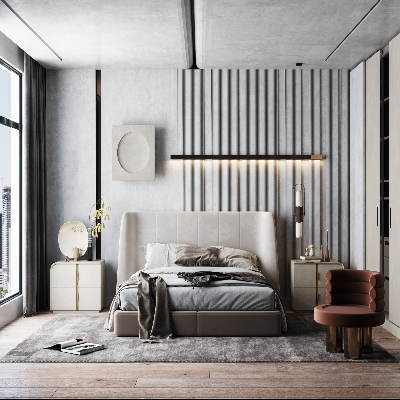

In [302]:
img = cv2.resize(cv2.imread('222.jpg'),(400,400))
img.shape
show(img)

In [301]:
image_prediction = np.argmax(model.predict(np.array([img])))
print(CLASSES[image_prediction])

Modern


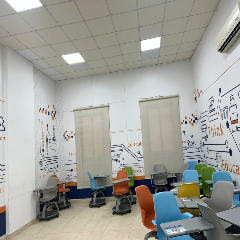

In [285]:
img_2 = cv2.resize(cv2.imread('4.jpg'),(240,240))
img_2.shape
show(img_2)


In [293]:
image_prediction = np.argmax(model.predict(np.array([img_2])))
print(CLASSES[image_prediction])

Old


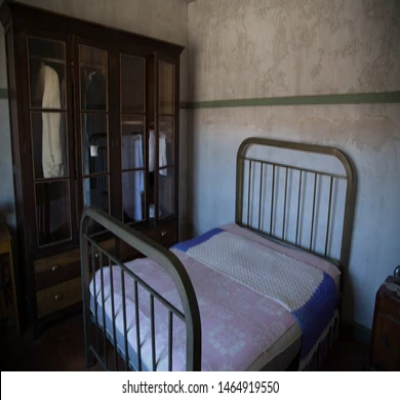

In [303]:
img_3 = cv2.resize(cv2.imread('9.jpg'),(400,400))
img_3.shape
show(img_3)

In [299]:
image_prediction = np.argmax(tuned_model.predict(np.array([img_3])))
print(CLASSES[image_prediction])

Old


In [297]:
img_3 = cv2.resize(cv2.imread('9.jpg'),(240,240))
img_3.shape
show(img_3)
image_prediction = np.argmax(tuned_model.predict(np.array([img_3])))
print(CLASSES[image_prediction])

Old


# References:

https://www.kaggle.com/mrdaniilak/image-classification-efficientnet-91 

https://towardsdatascience.com/all-the-steps-to-build-your-first-image-classifier-with-code-cf244b015799

https://towardsdatascience.com/end-to-end-deep-learning-project-part-1-930af1e1e191

https://xueshu.baidu.com/usercenter/paper/show?paperid=17719a545a95e9368613081593737c9a&site=xueshu_se